Number of training samples: 30409
Number of validation samples: 7603
Number of test samples: 144000
Training Set:


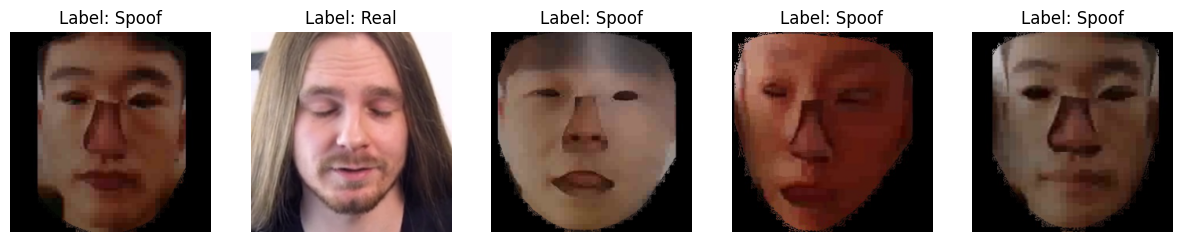

Validation Set:


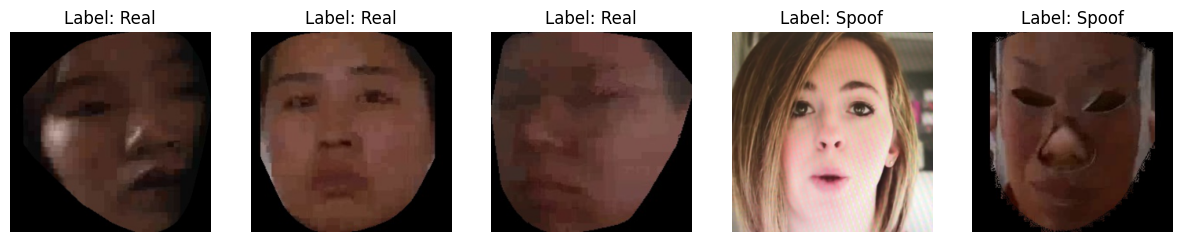

Test Set:


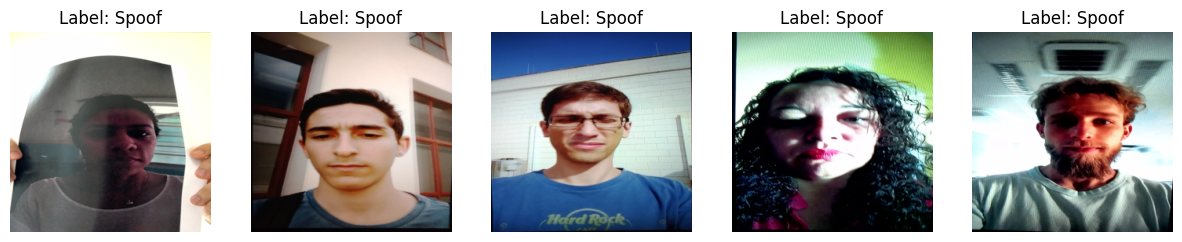

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import random

# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformation for resizing and tensor conversion
transform_standard = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Dataset Class Definitions

class CustomDataset(Dataset):
    def __init__(self, dataset_path, txt_file_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.samples = []

        # Read the txt file and collect paths for images along with their labels
        with open(txt_file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                color_path, _, _, label = line.strip().split()
                color_full_path = os.path.join(self.dataset_path, color_path)
                if os.path.exists(color_full_path):
                    self.samples.append((color_full_path, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, label = self.samples[idx]
        image = mpimg.imread(color_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


class BinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for category in ["attack_cce", "attack_hp", "attack_print1", "attack_print2", "real"]:
            label = 0 if category.startswith("attack") else 1
            category_dir = os.path.join(root_dir, category)
            for root, _, files in os.walk(category_dir):
                for file in files:
                    if file.endswith(".jpg"):
                        self.data.append((os.path.join(root, file), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = mpimg.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


class SpoofDataset(Dataset):
    def __init__(self, root_dir, category, label, transform=None):
        self.root_dir = os.path.join(root_dir, category)
        self.transform = transform
        self.data = []
        self.label = label

        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(".png"):
                    self.data.append(os.path.join(root, file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = mpimg.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.label, dtype=torch.long)


# Load LCC FASD Dataset for Training and Validation
root_dir = "/media/pria/New Volume/Spoofing/Datasets/LCC_FASD_CASIA/lcc-fasd-casia/LCC_FASD/"
real_train_dataset = SpoofDataset(root_dir=root_dir + "LCC_FASD_training", category="real", label=1, transform=transform_standard)
spoof_train_dataset = SpoofDataset(root_dir=root_dir + "LCC_FASD_training", category="spoof", label=0, transform=transform_standard)

# Load CASIA Dataset for Training and Validation
casia_train_dataset = CustomDataset(
    dataset_path="/media/pria/New Volume/Spoofing/Datasets/CASIA-SURF-Challenge/",
    txt_file_path="/media/pria/New Volume/Spoofing/Datasets/CASIA-SURF-Challenge/train_list.txt",
    transform=transform_standard
)

# Load ReCod Dataset for Testing
recod_test_dataset = BinaryDataset(
    root_dir="/media/pria/New Volume/Spoofing/Datasets/2020-plosone-recod-mpad/",
    transform=transform_standard
)

# Combine LCC FASD and CASIA datasets for training and validation
combined_train_val_dataset = ConcatDataset([real_train_dataset, spoof_train_dataset, casia_train_dataset])

# Split combined dataset into training and validation sets
train_size = int(0.8 * len(combined_train_val_dataset))
val_size = len(combined_train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_train_val_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Create DataLoaders for training, validation, and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(recod_test_dataset, batch_size=batch_size, shuffle=True)

# Count real and spoof samples for confirmation
num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)
num_test_samples = len(recod_test_dataset)
print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of test samples: {num_test_samples}")

# Function to show a few images with their labels
def show_images(dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for idx, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {'Real' if label.item() == 1 else 'Spoof'}")
        axes[idx].axis('off')
    plt.show()

# Show a few images from the training set
print("Training Set:")
show_images(train_loader)

# Show a few images from the validation set
print("Validation Set:")
show_images(val_loader)

# Show a few images from the test set
print("Test Set:")
show_images(test_loader)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import os
import json

# Directory to save model and7logs
save_path = '../models/trial89'
os.makedirs(save_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleResNetModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(SimpleResNetModel, self).__init__()
        # Load ResNet-18 with pretrained weights
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        # Replace the final fully connected layer to match the number of classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = SimpleResNetModel(pretrained=True).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # Set as needed
best_val_accuracy = 0.0
train_log = []

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        train_correct += (predictions == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            valid_correct += (predictions == labels).sum().item()

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    valid_loss /= len(val_loader.dataset)
    valid_accuracy = valid_correct / len(val_loader.dataset)

    # Save the model with the best validation accuracy
    if valid_accuracy > best_val_accuracy:
        best_val_accuracy = valid_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, f'best_model.pth'))

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    epoch_log = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'valid_loss': valid_loss,
        'valid_accuracy': valid_accuracy,
        'apcer': apcer,
        'bpcer': bpcer,
        'acer': acer,
        'hter': hter,
        'eer': eer
    }
    train_log.append(epoch_log)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

# Save the training log
with open(os.path.join(save_path, 'train_log.json'), 'w') as f:
    json.dump(train_log, f, indent=4)


Validation Epoch 1/10: 100%|█████████████████| 238/238 [02:34<00:00,  1.54it/s]


Epoch 1/10
Train Loss: 0.0760, Train Accuracy: 0.9712
Valid Loss: 0.2209, Valid Accuracy: 0.9061
APCER: 0.1133, BPCER: 0.0417, ACER: 0.0775, HTER: 0.0939, EER: 0.0417


Validation Epoch 2/10: 100%|█████████████████| 238/238 [02:36<00:00,  1.52it/s]


Epoch 2/10
Train Loss: 0.0509, Train Accuracy: 0.9817
Valid Loss: 0.0616, Valid Accuracy: 0.9774
APCER: 0.0007, BPCER: 0.0815, ACER: 0.0411, HTER: 0.0226, EER: 0.0815


Validation Epoch 3/10: 100%|█████████████████| 238/238 [02:36<00:00,  1.52it/s]


Epoch 3/10
Train Loss: 0.0361, Train Accuracy: 0.9875
Valid Loss: 0.0362, Valid Accuracy: 0.9867
APCER: 0.0101, BPCER: 0.0218, ACER: 0.0160, HTER: 0.0133, EER: 0.0218


Validation Epoch 4/10: 100%|█████████████████| 238/238 [02:33<00:00,  1.55it/s]


Epoch 4/10
Train Loss: 0.0298, Train Accuracy: 0.9890
Valid Loss: 0.0319, Valid Accuracy: 0.9884
APCER: 0.0137, BPCER: 0.0058, ACER: 0.0098, HTER: 0.0116, EER: 0.0058


Validation Epoch 5/10: 100%|█████████████████| 238/238 [02:31<00:00,  1.57it/s]


Epoch 5/10
Train Loss: 0.0251, Train Accuracy: 0.9911
Valid Loss: 0.0271, Valid Accuracy: 0.9907
APCER: 0.0065, BPCER: 0.0170, ACER: 0.0117, HTER: 0.0093, EER: 0.0170


Validation Epoch 6/10: 100%|█████████████████| 238/238 [02:35<00:00,  1.53it/s]


Epoch 6/10
Train Loss: 0.0244, Train Accuracy: 0.9914
Valid Loss: 0.0203, Valid Accuracy: 0.9920
APCER: 0.0078, BPCER: 0.0087, ACER: 0.0082, HTER: 0.0080, EER: 0.0087


Validation Epoch 7/10: 100%|█████████████████| 238/238 [02:36<00:00,  1.52it/s]


Epoch 7/10
Train Loss: 0.0159, Train Accuracy: 0.9944
Valid Loss: 0.0155, Valid Accuracy: 0.9930
APCER: 0.0011, BPCER: 0.0228, ACER: 0.0119, HTER: 0.0070, EER: 0.0228


Validation Epoch 8/10: 100%|█████████████████| 238/238 [02:33<00:00,  1.55it/s]


Epoch 8/10
Train Loss: 0.0157, Train Accuracy: 0.9946
Valid Loss: 0.0206, Valid Accuracy: 0.9915
APCER: 0.0022, BPCER: 0.0257, ACER: 0.0139, HTER: 0.0085, EER: 0.0257


Validation Epoch 9/10: 100%|█████████████████| 238/238 [02:27<00:00,  1.61it/s]


Epoch 9/10
Train Loss: 0.0136, Train Accuracy: 0.9952
Valid Loss: 0.0290, Valid Accuracy: 0.9895
APCER: 0.0002, BPCER: 0.0383, ACER: 0.0193, HTER: 0.0105, EER: 0.0383


Validation Epoch 10/10: 100%|████████████████| 238/238 [02:34<00:00,  1.55it/s]


Epoch 10/10
Train Loss: 0.0142, Train Accuracy: 0.9952
Valid Loss: 0.0176, Valid Accuracy: 0.9938
APCER: 0.0042, BPCER: 0.0116, ACER: 0.0079, HTER: 0.0062, EER: 0.0116


## Evalution

## Train set evalution

/tmp/ipykernel_218965/611241064.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Evaluating Train


Results for Training Set:
Loss: 0.0107, Accuracy: 0.9963
APCER: 0.0029, BPCER: 0.0057, ACER: 0.0043, HTER: 0.0037, EER: 0.0057

Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00     22226
        Real       0.99      0.99      0.99      8183

    accuracy                           1.00     30409
   macro avg       1.00      1.00      1.00     30409
weighted avg       1.00      1.00      1.00     30409

Confusion Matrix:
[[22162    64]
 [   47  8136]]


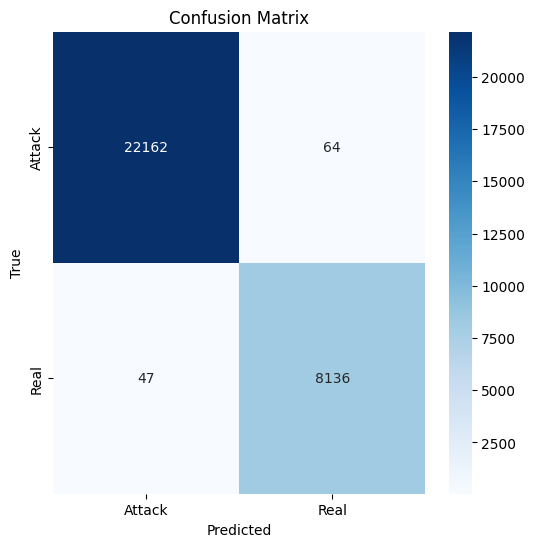


Visualizing predictions (Predicted vs Ground Truth):


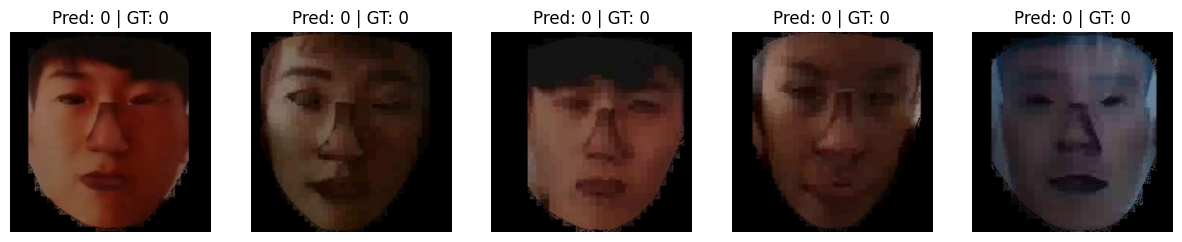

In [3]:
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Directory where the model is saved
save_path = '../models/trial89'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = SimpleResNetModel(pretrained=True).to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to evaluate loader and visualize predictions
def evaluate_loader(loader, loader_name="Dataset", num_images_to_show=5):
    correct = 0
    total = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    eval_loss = 0.0

    all_preds = []
    all_labels = []
    
    images_to_visualize = []
    pred_labels_to_visualize = []
    gt_labels_to_visualize = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {loader_name}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
            outputs = model(images)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * images.size(0)

            predictions = torch.round(torch.sigmoid(outputs))
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Visualize some images
            if len(images_to_visualize) < num_images_to_show:
                images_to_visualize.extend(images.cpu()[:num_images_to_show - len(images_to_visualize)])
                pred_labels_to_visualize.extend(predictions.cpu()[:num_images_to_show - len(pred_labels_to_visualize)])
                gt_labels_to_visualize.extend(labels.cpu()[:num_images_to_show - len(gt_labels_to_visualize)])

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    # Calculate metrics
    eval_loss /= total
    accuracy = correct / total

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    # Print out the results for the current loader
    print(f"\nResults for {loader_name}:")
    print(f"Loss: {eval_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Attack', 'Real']))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, class_names=['Attack', 'Real'])

    # Visualize a few images with predictions
    print("\nVisualizing predictions (Predicted vs Ground Truth):")
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 15))
    for idx, (img, pred_label, gt_label) in enumerate(zip(images_to_visualize, pred_labels_to_visualize, gt_labels_to_visualize)):
        img = img.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        axes[idx].imshow(img)
        axes[idx].set_title(f"Pred: {int(pred_label.item())} | GT: {int(gt_label.item())}")
        axes[idx].axis('off')
    plt.show()

# Evaluate on all three loaders (training, validation, and test)

# 1. Evaluate on train_loader (Real vs Spoof for training set)
evaluate_loader(train_loader, loader_name="Training Set", num_images_to_show=5)



## val set eval

Evaluating Validation Set: 100%|█████████████| 238/238 [02:32<00:00,  1.56it/s]


Results for Validation Set:
Loss: 0.0176, Accuracy: 0.9938
APCER: 0.0042, BPCER: 0.0116, ACER: 0.0079, HTER: 0.0062, EER: 0.0116

Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00      5542
        Real       0.99      0.99      0.99      2061

    accuracy                           0.99      7603
   macro avg       0.99      0.99      0.99      7603
weighted avg       0.99      0.99      0.99      7603

Confusion Matrix:
[[5519   23]
 [  24 2037]]


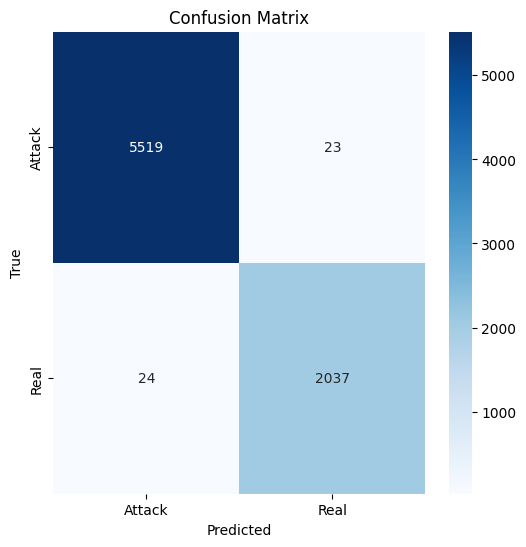


Visualizing predictions (Predicted vs Ground Truth):


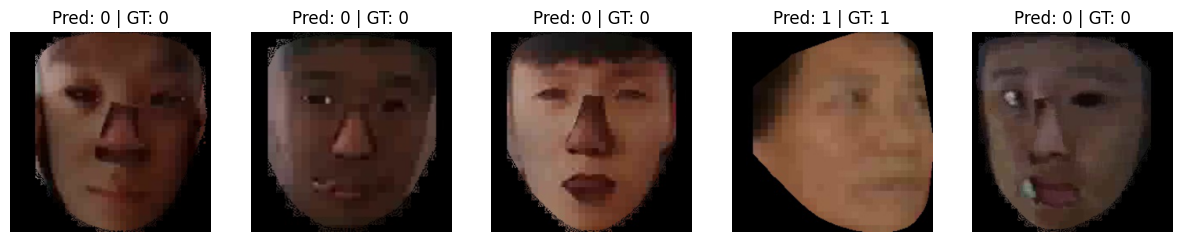

In [4]:
# 2. Evaluate on val_loader (Real vs Spoof for validation set)
evaluate_loader(val_loader, loader_name="Validation Set", num_images_to_show=5)




## Test set Eval (Cross dataset)

Evaluating Test Set: 100%|███████████████| 4500/4500 [2:07:05<00:00,  1.69s/it]



Results for Test Set:
Loss: 0.6658, Accuracy: 0.7662
APCER: 0.1608, BPCER: 0.5257, ACER: 0.3433, HTER: 0.2338, EER: 0.5257

Classification Report:
              precision    recall  f1-score   support

      Attack       0.86      0.84      0.85    115200
        Real       0.42      0.47      0.45     28800

    accuracy                           0.77    144000
   macro avg       0.64      0.66      0.65    144000
weighted avg       0.78      0.77      0.77    144000

Confusion Matrix:
[[96674 18526]
 [15140 13660]]


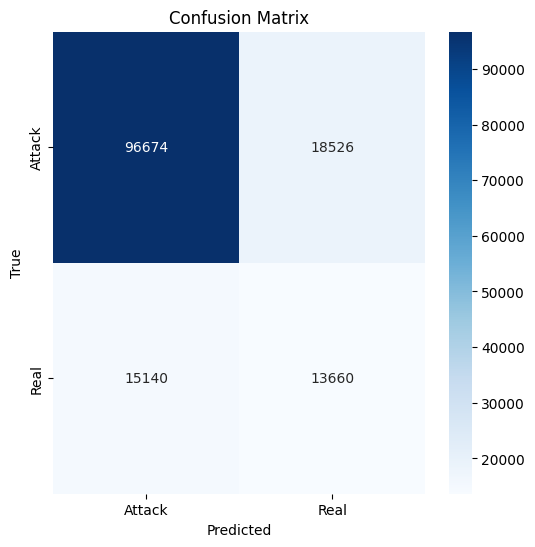


Visualizing predictions (Predicted vs Ground Truth):


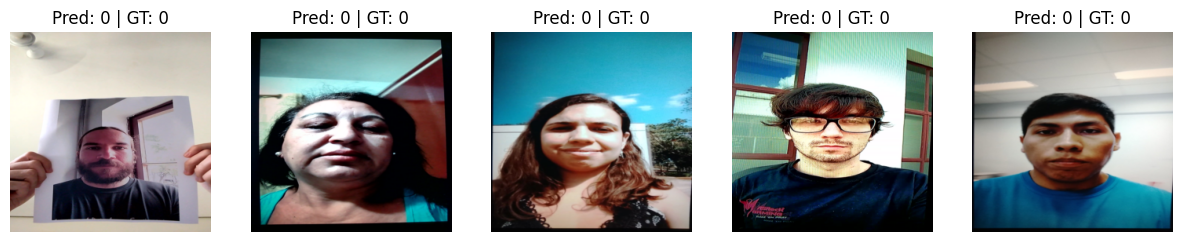

In [5]:
# 3. Evaluate on test_loader (Real vs Spoof for test set)
evaluate_loader(test_loader, loader_name="Test Set", num_images_to_show=5)